In [1]:
!pip install fancyimpute --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
nnabla 1.32.0 requires protobuf<=3.19.4; platform_system != "Windows", but you have protobuf 3.20.3 which is incompatible.
gcsfs 2022.5.0 requires fsspec==2022.5.0, but you have fsspec 2022.11.0 which is incompatible.
cloud-tpu-client 0.10 requires google-api-python-client==1.8.0, but you have google-api-python-client 2.52.0 which is incompatible.


In [2]:
# Basic libraries
import numpy as np
import pandas as pd

# Visualisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from matplotlib.pyplot import rcParams

# Image library
import matplotlib.image as image

# Libraries for data processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from fancyimpute import KNN, IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Hypertuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Performance Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

# Warings
import warnings
warnings.filterwarnings('ignore')

# setting up matplotlib to use jupyter's own backend for visualisation
%matplotlib inline

(CVXPY) Oct 18 01:23:30 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 18 01:23:30 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [3]:
sns.set_style('darkgrid')
rcParams['figure.figsize'] = [8,8]

In [4]:
df_train= pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- <font color="darkviolet"> Out of the total passengers, 38.38% of passengers survived
- <font color="darkviolet"> The age of passengers ranges from 0.42 to 80 years with the median at 28 years
- <font color="darkviolet"> Median Fare was 14.5 USD. 25th and 75th quantiles are at 8 USD and 31 USD. However, the maximum fare was 512 USD indicating there are outliers in the Fare.

In [6]:
# checking duplicated values
df_train.duplicated().sum()

0

<font color="darkviolet"> There are no duplicate values in the dataset

Univariate Analysis

In [7]:
# Extracting unique values from all columns
dict_uniques= {}

for col in df_train:
    
    if len(df_train[col].unique())< 5:
        
        dict_uniques[col]=df_train[col].unique()
                                
        
    else:
        continue
        
print(dict_uniques)

{'Survived': array([0, 1]), 'Pclass': array([3, 1, 2]), 'Sex': array(['male', 'female'], dtype=object), 'Embarked': array(['S', 'C', 'Q', nan], dtype=object)}


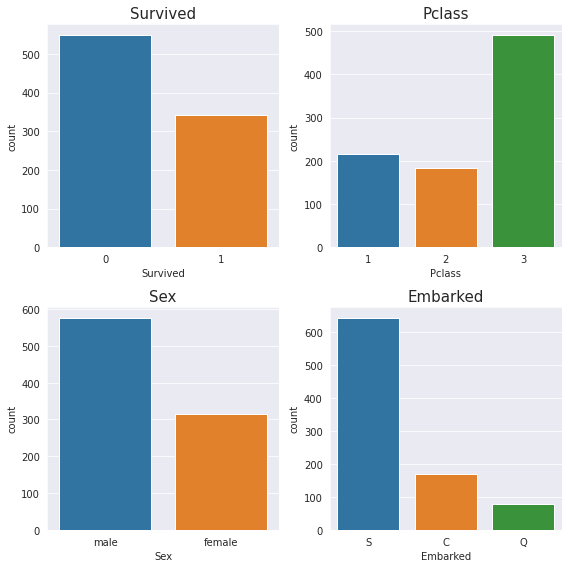

In [8]:
columns= dict_uniques.keys()

fig, ax= plt.subplots(2,2, figsize=(8,8))

for col, ax in zip(columns, ax.flatten()):
    sns.countplot(df_train[col], ax=ax)
    ax.set_title(col.title(), fontsize=15)
   
    plt.tight_layout()

- <font color="darkviolet"> Tragically, 549 passengers i.e 62% of total passengers, lost their lives in the disaster. Only 342 passengers survived the accident
- <font color="darkviolet"> Death rate was much higher than the survival rate.
- <font color="darkviolet"> Maximum passengers were in class 3 which is more than double the passengers in class 1 and class 2 each
- <font color="darkviolet"> The number of male passengers was almost twice that of female passengers
- <font color="darkviolet"> Most of the passengers embarked on the ship at Port Southampton(S) which is almost 4 times that of port C and 9 times that of Port Q.


Survival Analysis

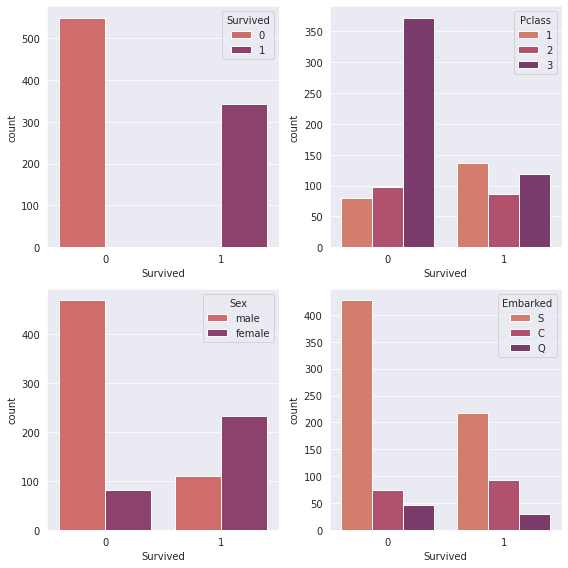

In [9]:
hue= dict_uniques.keys()
fig, ax=plt.subplots(2,2, figsize=(8,8))

for col, ax in zip(hue, ax.flatten()):
    
    sns.countplot(x='Survived', data=df_train, hue=col, ax=ax, palette='flare');

plt.tight_layout()


Analysing Age Distribution

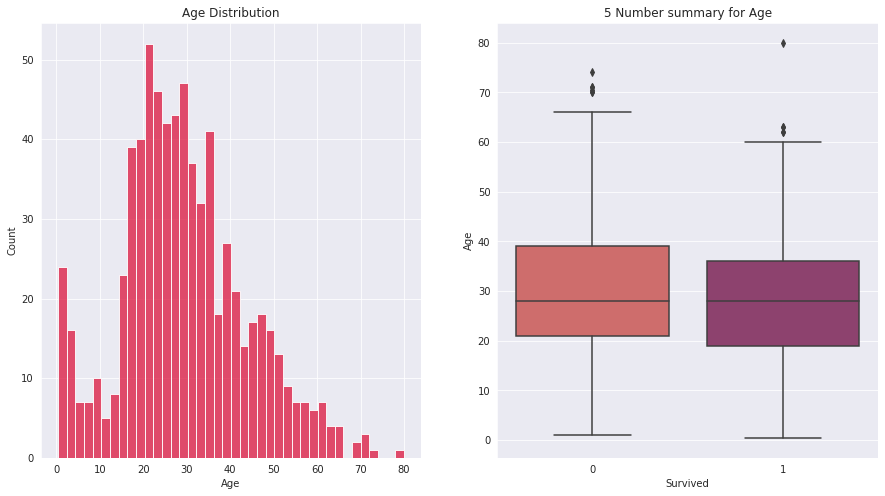

In [10]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
sns.histplot(x='Age', data=df_train, kde=False, bins=40, color='crimson')
plt.title('Age Distribution')

plt.subplot(1,2,2);
sns.boxplot(y='Age', x='Survived', data=df_train, palette='flare')
plt.title("5 Number summary for Age");


 From the age distibution we can see that most of passengers were of age between 18 to 40 years. Age distribution is right skewed as age is dispersed more on the right side
 Age is appeared to be more dispersed on the higher side for passengers who lost their lives. The median age of both dead and survived looks almost the same. There are few outliers present in the Age column

#### Creating bins for Age

In [11]:
not_survived= df_train[df_train["Survived"]==0]

In [12]:
not_survived["age_cat"] =pd.cut(df_train["Age"],
                        bins = [0,18,36,54,72, np.Inf],
                        labels=[1,2,3,4,5])

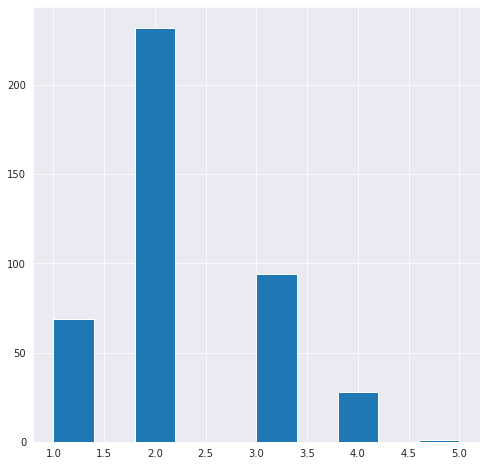

In [13]:
not_survived["age_cat"].hist();

Maximum number of passengers who did not survive were between age group 18 to 36 years

Fare Distribution

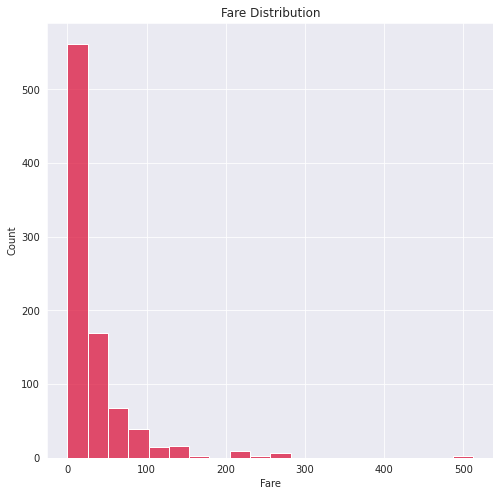

In [14]:
sns.histplot(x='Fare', data=df_train, bins=20, color='crimson')
plt.title('Fare Distribution');

In [15]:
not_survived["fare_cat"] =pd.cut(df_train["Fare"],
                        bins = [0,30,60,90,120, np.Inf],
                        labels=[1,2,3,4,5])

<AxesSubplot:>

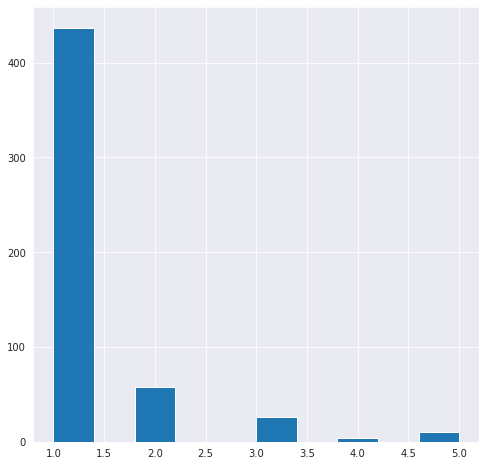

In [16]:
not_survived["fare_cat"].hist()

 The fare is not normally distributed. There are many outliers present in the data. Instead of relying on fare column, we will create bins (Classed)) to group the passengers based on the fare. First we have fitered out the passengers who lost their lives. Then we have created 5 bins for fares such as 0-30, 30-60, 60-90, 90-120 and more than 120 USD. We can see that maximum number of passengers who lost their lives, paid fare between 0 to 30 USD.

Fare vs Age</span>

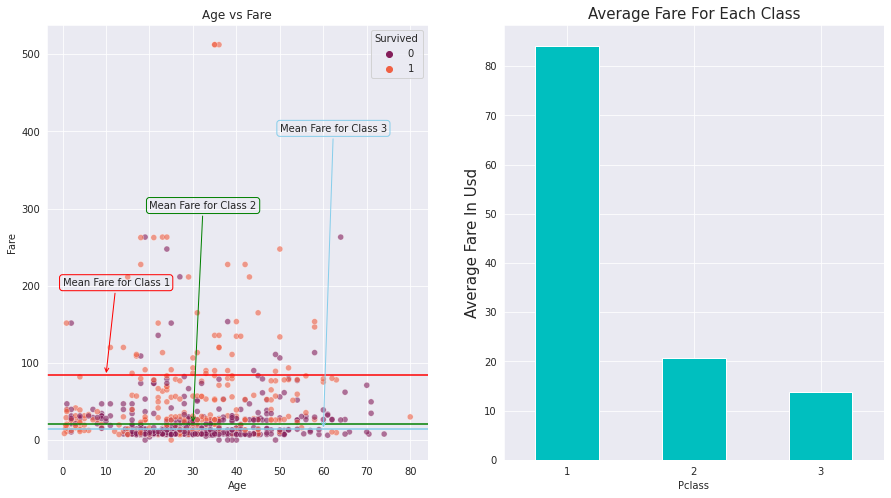

In [17]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
sns.scatterplot(x='Age',y='Fare', data=df_train, hue='Survived',palette='rocket', alpha=0.6)
df_class= df_train.groupby('Pclass')['Fare'].mean()
plt.axhline(y=84.15, c='r', label='Class 1')
plt.axhline(y=20.66, c='g', label='Class 2')
plt.axhline(y=13.67, c='skyblue', label='Class 3')
#plt.legend(['Class 1', 'Class 2','Class3','0','1'])
plt.title('Age vs Fare')
plt.annotate('Mean Fare for Class 1', (10, 84.15), (0, 200),
            arrowprops=dict(arrowstyle="->",connectionstyle="Arc3", color="r"),
            bbox = dict(boxstyle = "round", fc ="none", ec="r"))

plt.annotate('Mean Fare for Class 2', (30, 20.66), (20, 300),
            arrowprops=dict(arrowstyle="->",connectionstyle="Arc3", color="g"),
            bbox = dict(boxstyle = "round", fc ="none", ec="g"))

plt.annotate('Mean Fare for Class 3', (60, 13.67), (50, 400),
            arrowprops=dict(arrowstyle="->",connectionstyle="Arc3", color="skyblue"),
            bbox = dict(boxstyle = "round", fc ="none", ec="skyblue"))

plt.subplot(1,2,2)
df_class= df_train.groupby('Pclass')['Fare'].mean()
df_class.plot(kind='bar', color='c')
plt.xticks(rotation=360)
plt.title('Average Fare for each class'.title(), fontsize=15)
plt.ylabel('Average Fare in USD'.title(), fontsize=15);

In [18]:
print('Relationship between Age and Fare:', df_train['Age'].corr(df_train['Fare']))
print('Relationship between Pclass and Fare:', df_train['Pclass'].corr(df_train['Fare']))

Relationship between Age and Fare: 0.0960666917690389
Relationship between Pclass and Fare: -0.5494996199439074


Age and Fare show a weak relationship. As expected, Fare is dependent upon the class with minimal relevance to the age of the passenger

The Scatter plot between Age and fare also shows that passengers who died also clustered around classes 2 and 3 with low fares. It supports our previous finding that class 1 passengers were prviledged and evacuated first. The average fare paid by class 1 passengers was more than that of combined class 2 and 3 passengers.

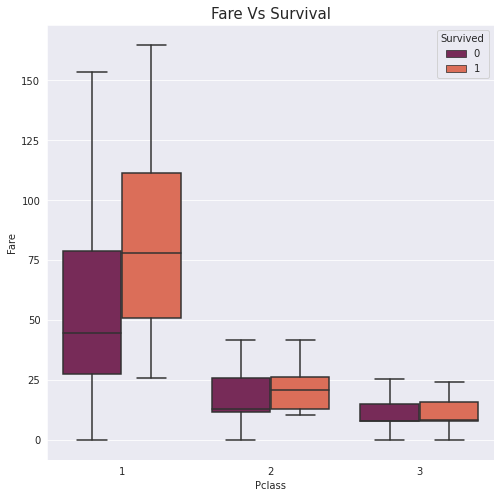

In [19]:
sns.boxplot(x='Pclass', y='Fare', data=df_train, showfliers=False, hue='Survived', palette='rocket')
plt.title('Fare vs Survival'.title(), fontsize=15);

<font color="darkviolet">Passengers with higher fares were more likely to survive. For Class 3 passengers, median fare values for both survived and deceased passengers were the same which strongly suggests that preference was given to class 1 and 2 passengers

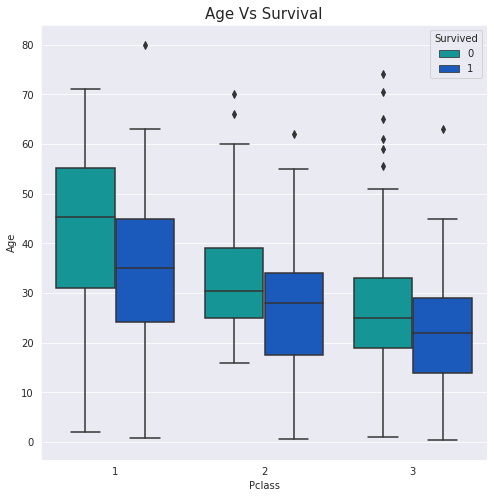

In [20]:
sns.boxplot(x='Pclass', y='Age', data=df_train, hue='Survived', showfliers=True, palette="winter_r")
plt.title('Age vs Survival'.title(), fontsize=15);

- <font color= "darkviolet">Age of passengers in class 1 is more dispersed than those in remaining classes. 
- <font color= "darkviolet">Median age of passengers also varies ascendingly from class 3 to class 1.
- <font color= "darkviolet">For all classes, median age of deseased passengers is greater than survived passenger

Feature Engineering

In [21]:
data = df_train.copy()

In [22]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We have two columns SibSp (Siblings and Spouse) and Parch(Parents and Children) in the dataset. These columns if combined forms the strength of the family of a passenger. let's create a new column Family representing the strength of the passengers' families.

In [23]:
data['Family']= data['SibSp'] + data['Parch']
data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0


Let's also add another column indicating whether a passenger is traveling 'alone' or in 'group'. If the value in 'Family' is 0 then we append 'alone' otherwise, we will append 'group'.

In [24]:
data['travelling_alone']=data['Family'].apply(lambda x: 1 if x==0 else 0)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,travelling_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1


As we have seen from the EDA, passengers who paid lesser were more likely to lose their lives. We will also add column "middle_class" in which we will append 1 if their fare is between 0 to 30 USD else we will append 0.

In [25]:
data['middle_class']=data['Fare'].apply(lambda x: 1 if (x>=0) and (x<=30) else 0)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,travelling_alone,middle_class
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1,1


In [26]:
data.corr()["Survived"].sort_values(ascending=False)

Survived            1.000000
Fare                0.257307
Parch               0.081629
Family              0.016639
PassengerId        -0.005007
SibSp              -0.035322
Age                -0.077221
travelling_alone   -0.203367
middle_class       -0.242191
Pclass             -0.338481
Name: Survived, dtype: float64

Data Preparation

In [27]:
# Seperating features and labels
data=df_train.drop("Survived", axis=1)
labels= df_train["Survived"]

In [28]:
titanic = data.copy()

In [29]:
titanic.drop(columns=["PassengerId", "Name", "Ticket"], inplace=True )
titanic.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,NaN,S
1,1,female,38.0,1,0,71.2833,C85,C
2,3,female,26.0,0,0,7.9250,NaN,S
3,1,female,35.0,1,0,53.1000,C123,S
4,3,male,35.0,0,0,8.0500,NaN,S


Missing Values</span>

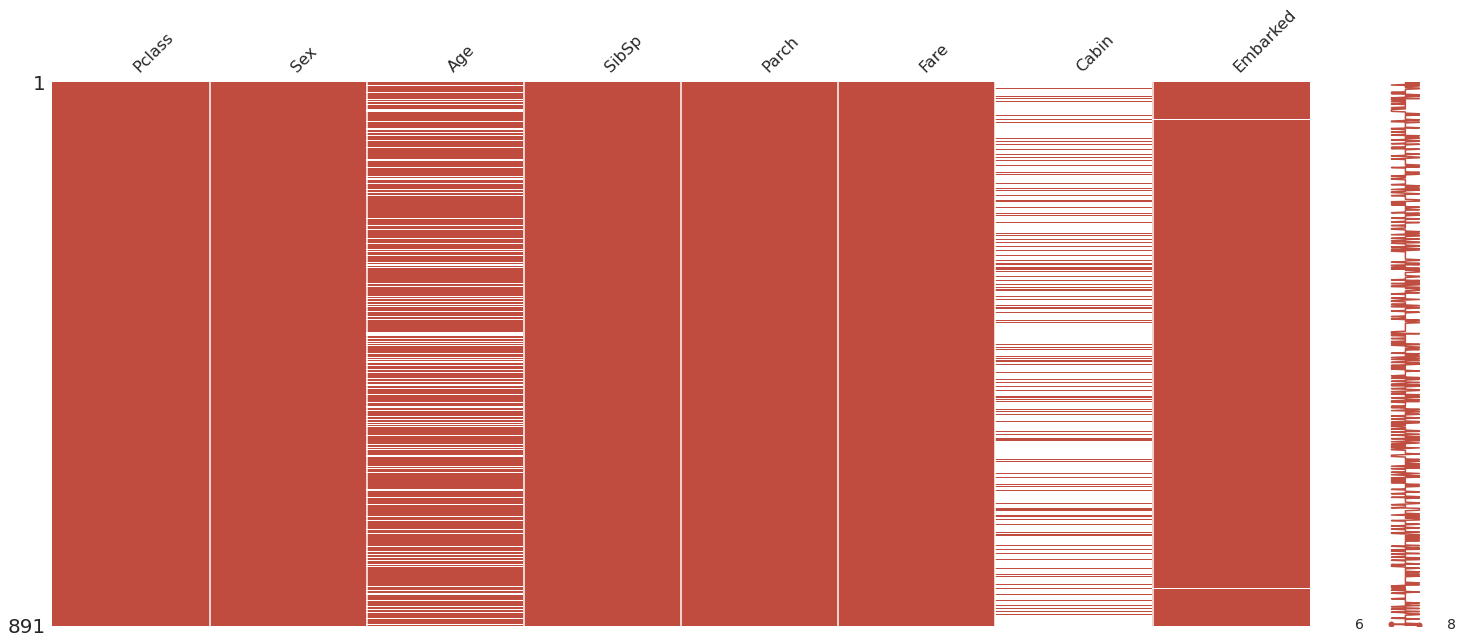

In [30]:
# heatmap for complete dataset to check missing values
msno.matrix(titanic,color=(0.75, 0.3, 0.25));

In [31]:
titanic.isna().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [32]:
# getting percentage of missing values 
titanic.isna().mean()*100

Pclass       0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

- <font color="darkviolet">Out of 891 records, there are 177 values are missing from the Age column which is 19% of the total entries. As it is still not significantly high, we can replace these values imputation technique. 
- Critically, around 77% of Cabin data is missing. Dropping rows for these values will adversely affect our dataset and analysis. 
- In addition, 2 entries are also unavailable in Embarked column.

### Cabin Column

<font color="darkviolet">Since 77% of cabin entries are missing, it will not make sense to replace these values. So we will completely drop the cabin column

In [33]:
titanic.drop(columns=['Cabin'], inplace=True)

### Embarked Column

In [34]:
# first seperating numberical and categorical columns
titanic_num= titanic[["Pclass", "Age", "SibSp", "Parch", "Fare"]]
titanic_cat = titanic[["Sex", "Embarked"]]

<font color="darkviolet">Only 2 entries are missing from the Embarked column. We will replace missing values with mode, i.e. port S

In [35]:
df_mode = titanic_cat.copy()
mode_imputer = SimpleImputer(strategy="most_frequent")
df_mode.iloc[:, 1:] = mode_imputer.fit_transform(df_mode.iloc[:, 1:])

In [36]:
df_mode.isna().sum()

Sex         0
Embarked    0
dtype: int64

In [37]:
# mean imputation
df_mean = titanic_num.copy()
mean_imputer = SimpleImputer(strategy = "mean")
df_mean.iloc[:,:] = mean_imputer.fit_transform(df_mean)

In [38]:
# median imputation
df_median =titanic_num.copy()
median_imputer = SimpleImputer(strategy = "median")
df_median.iloc[:,:] = median_imputer.fit_transform(df_median)

In [39]:
# KNN imputation
df_knn = titanic_num.copy()
knn_imputer = KNNImputer()
df_knn.iloc[:,:]= knn_imputer.fit_transform(df_knn)

In [40]:
# MICE imputation
df_mice= titanic_num.copy()
mice_imputer = IterativeImputer()
df_mice.iloc[:,:]= mice_imputer.fit_transform(df_mice)

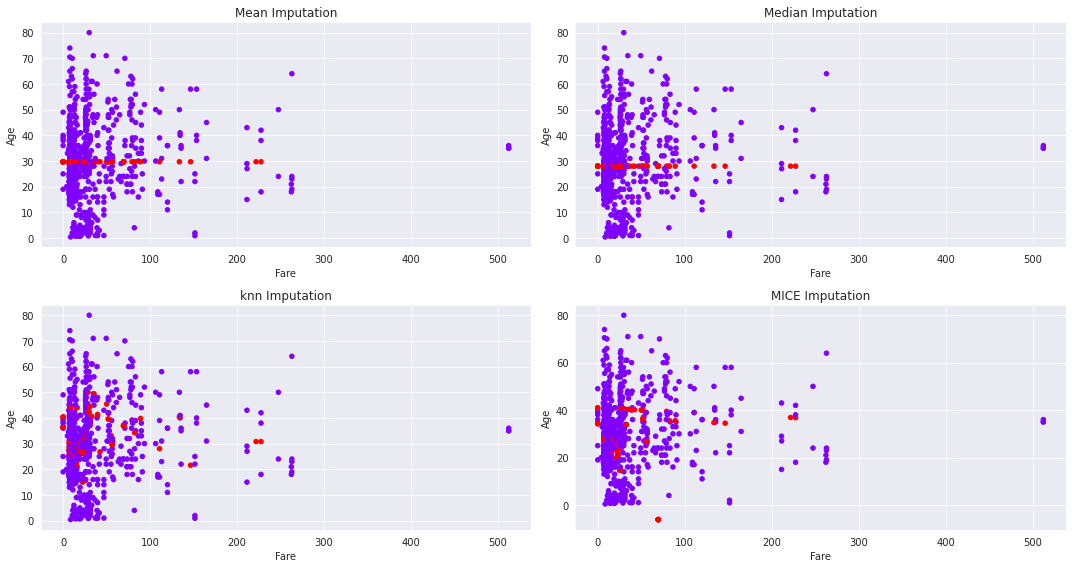

In [41]:
# let's analyse all above imputation results visually
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(15,8))

nullity = titanic["Age"].isna()
imputations = {"Mean Imputation": df_mean,
               "Median Imputation": df_median,
               "knn Imputation": df_knn,
              "MICE Imputation": df_mice}

for ax, key in zip(ax.flatten(), imputations):
    
    imputations[key].plot(x = "Fare", y = "Age", kind="scatter", 
                             ax=ax, c=nullity, cmap="rainbow", title=key, colorbar=None)
    

    plt.tight_layout();

The graphs are plotted with Fare values on x-axis and Age on y-axis. Imputed values are represented by red dots. 
- <font color="darkviolet">Mean and Median imputation techniques fill constant values so, we see the imputed missing values along the straight horizontal line</font>
- <font color="darkviolet">As KNN and MICE Imputation techniques are distance based, values are imputed based on nearest distance to the other observations. Hence, they give results close to the original data. </font>

Before we select the imputation method, lets also have a look at the Age distribution. Ideally our manual imputation should not alter the original distribution.

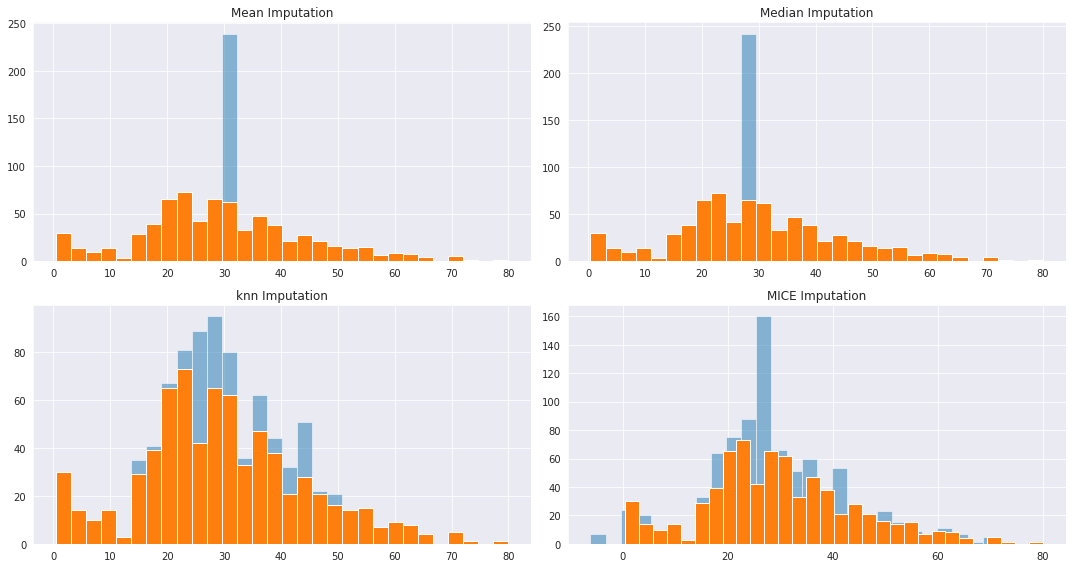

In [42]:
# Checking the effect of imputation on the original distribution
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(15,8))

imputations = {"Mean Imputation": df_mean,
               "Median Imputation": df_median,
               "knn Imputation": df_knn,
              "MICE Imputation": df_mice}

for ax, key in zip(ax.flatten(), imputations):
    imputations[key].hist("Age", bins=30, ax=ax, alpha=0.5)
    titanic.hist("Age",bins=30, ax=ax)
    ax.set_title(key)
    plt.tight_layout()

In [43]:
cat_encoder = OneHotEncoder(drop="first")

In [44]:
titanic_cat_ohe = cat_encoder.fit_transform(df_mode)

In [45]:
titanic_cat_ohe

<891x3 sparse matrix of type '<class 'numpy.float64'>'
	with 1300 stored elements in Compressed Sparse Row format>

In [46]:
cat_encoder.categories_

[array(['female', 'male'], dtype=object), array(['C', 'Q', 'S'], dtype=object)]

In [47]:
scaled_titanic = df_knn.copy()

In [48]:
scaler = StandardScaler()

In [49]:
scaled_titanic[["Age", "Fare"]] = scaler.fit_transform(scaled_titanic[["Age", "Fare"]])

In [50]:
scaled_titanic.head()

,Pclass,Age,SibSp,Parch,Fare
0,3.0,-0.596778,1.0,0.0,-0.502445
1,1.0,0.585986,1.0,0.0,0.786845
2,3.0,-0.301087,0.0,0.0,-0.488854
3,1.0,0.364218,1.0,0.0,0.420730
4,3.0,0.364218,0.0,0.0,-0.486337


In [51]:
titanic_num.head()

,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


In [52]:
sibch_index, parch_index, fare_index = 2,3,4

class CombineedAttributesAdder(BaseEstimator, TransformerMixin):

    def __init__(self, add_travelling_alone=True, add_middle_class=True):
        self.add_travelling_alone=add_travelling_alone
        self.add_middle_class= add_middle_class

    def fit(self, X):
        return self 

    def transform(self, X, y=None):
        family = X[:, sibch_index] +X[:, parch_index]
        family = family
        
        travelling_alone=[]
        for val in family:
            if val==0:
                travelling_alone.append(1)
            else:
                travelling_alone.append(0)

        middle_class = []
        for fare_val in X[:, fare_index]:
            if (fare_val >=0) and (fare_val<=30):
                middle_class.append(1)
            else:
                middle_class.append(0)

        if (self.add_travelling_alone) & (self.add_middle_class): 
            return np.c_[X, travelling_alone, middle_class]

        elif (self.add_middle_class) & (~self.add_travelling_alone): 
            return np.c_[X, middle_class]

        elif (~self.add_middle_class) & (self.add_travelling_alone):
            return np.c_[X, travelling_alone]

        else:
            return X



In [53]:
attr_adder= CombineedAttributesAdder(add_travelling_alone=True, add_middle_class=True)

In [54]:
titanic_extra_attrbs= attr_adder.transform(titanic_num.values)

In [55]:
pd.DataFrame(titanic_extra_attrbs)

,0,1,2,3,4,5,6
0,3.0,22.0,1.0,0.0,7.2500,0.0,1.0
1,1.0,38.0,1.0,0.0,71.2833,0.0,0.0
2,3.0,26.0,0.0,0.0,7.9250,1.0,1.0
3,1.0,35.0,1.0,0.0,53.1000,0.0,0.0
4,3.0,35.0,0.0,0.0,8.0500,1.0,1.0
...,...,...,...,...,...,...,...
886,2.0,27.0,0.0,0.0,13.0000,1.0,1.0
887,1.0,19.0,0.0,0.0,30.0000,1.0,1.0
888,3.0,NaN,1.0,2.0,23.4500,0.0,1.0
889,1.0,26.0,0.0,0.0,30.0000,1.0,1.0


In [56]:
numeric_pipeline = Pipeline([
    ('num_imputer', KNNImputer()),
    ('attr_adder', CombineedAttributesAdder(add_middle_class=True, add_travelling_alone=False))
])

In [57]:
categorical_pipeline = Pipeline([
    ('cat_imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder())
])

In [58]:
full_pipeline = ColumnTransformer([
    ('num', numeric_pipeline, list(titanic_num)),
    ('cat', categorical_pipeline, list(titanic_cat)),
])

In [59]:
preprocessed_titanic = full_pipeline.fit_transform(titanic)

In [60]:
scaler = StandardScaler()
preprocessed_titanic_scaled= scaler.fit_transform(preprocessed_titanic)

In [61]:
pd.DataFrame(preprocessed_titanic_scaled)

,0,1,2,3,4,5,6,7,8,9,10
0,0.827377,-0.596778,0.432793,-0.473674,-0.502445,0.596795,-0.737695,0.737695,-0.482043,-0.307562,0.615838
1,-1.566107,0.585986,0.432793,-0.473674,0.786845,-1.675617,1.355574,-1.355574,2.074505,-0.307562,-1.623803
2,0.827377,-0.301087,-0.474545,-0.473674,-0.488854,0.596795,1.355574,-1.355574,-0.482043,-0.307562,0.615838
3,-1.566107,0.364218,0.432793,-0.473674,0.420730,-1.675617,1.355574,-1.355574,-0.482043,-0.307562,0.615838
4,0.827377,0.364218,-0.474545,-0.473674,-0.486337,0.596795,-0.737695,0.737695,-0.482043,-0.307562,0.615838
...,...,...,...,...,...,...,...,...,...,...,...
886,-0.369365,-0.227164,-0.474545,-0.473674,-0.386671,0.596795,-0.737695,0.737695,-0.482043,-0.307562,0.615838
887,-1.566107,-0.818547,-0.474545,-0.473674,-0.044381,0.596795,1.355574,-1.355574,-0.482043,-0.307562,0.615838
888,0.827377,-0.241949,0.432793,2.008933,-0.176263,0.596795,1.355574,-1.355574,-0.482043,-0.307562,0.615838
889,-1.566107,-0.301087,-0.474545,-0.473674,-0.044381,0.596795,-0.737695,0.737695,2.074505,-0.307562,-1.623803


With all this hard work, we have now successfully processed the training dataset in order to feed it to the model for training. Let's now move to the part which I was desparately waiting for...... i.e. Creating the machine learning model!!!!

Model

In [62]:
X_train = preprocessed_titanic_scaled.copy()
y_train = labels

Logistic Regression</span>

In [63]:
lr = LogisticRegression()

In [64]:
lr.fit(X_train, y_train)

LogisticRegression()

In [65]:
def display_results (test, pred):
    print("confusion matrix is:")
    print(confusion_matrix(test, pred))
    print('======================================================') 
    print("Accuracy score is:", accuracy_score(test, pred))  
    print('======================================================') 
    print("Precision is : ", precision_score(test, pred))
    print('======================================================') 
    print("Recall is : ", recall_score(test, pred))
    print('======================================================') 
    print("F1 score is : ", f1_score(test, pred))
    print('======================================================') 
    print("Classification report is:")
    print(classification_report(test, pred))

In [66]:
y_train_pred = lr.predict(X_train)
acc_lr =accuracy_score(y_train, y_train_pred)
f1_lr =f1_score(y_train, y_train_pred)

In [67]:
display_results(y_train, y_train_pred)

confusion matrix is:
[[476  73]
 [101 241]]
Accuracy score is: 0.8047138047138047
Precision is :  0.767515923566879
Recall is :  0.7046783625730995
F1 score is :  0.7347560975609757
Classification report is:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       549
           1       0.77      0.70      0.73       342

    accuracy                           0.80       891
   macro avg       0.80      0.79      0.79       891
weighted avg       0.80      0.80      0.80       891



SGD Classifier</span>

In [68]:
sgd = SGDClassifier()

In [69]:
sgd.fit(X_train, y_train)

SGDClassifier()

In [70]:
y_train_pred_sgd = sgd.predict(X_train)

In [71]:
acc_sgd =accuracy_score(y_train, y_train_pred_sgd)
f1_sgd =f1_score(y_train, y_train_pred_sgd)

In [72]:
display_results(y_train, y_train_pred_sgd)

confusion matrix is:
[[510  39]
 [167 175]]
Accuracy score is: 0.7687991021324355
Precision is :  0.8177570093457944
Recall is :  0.5116959064327485
F1 score is :  0.6294964028776978
Classification report is:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       549
           1       0.82      0.51      0.63       342

    accuracy                           0.77       891
   macro avg       0.79      0.72      0.73       891
weighted avg       0.78      0.77      0.75       891

